# Evaluating Tool-Use Errors with Limbic

This notebook evaluates how agents use tools, using the Limbic evaluator.  
It runs models on a compact dataset of tool-use tasks, checks their outputs against ground truth,  
and analyzes error patterns across categories (incorrect tool, incorrect parameter names, incorrect parameter values).  


## Setup  

We install required libraries and set up API keys for running models.  
- `together` for calling Kimi K2 and Qwen  
- Standard Python libraries for JSON handling and plotting

In [ ]:
!pip install --upgrade together

In [2]:
import os
import json
import time
from typing import Dict, List, Any, Optional
import requests
import pandas as pd
from datetime import datetime
import random
from collections import defaultdict, Counter
import ast
from tqdm import tqdm

from datasets import load_dataset
from together import Together

In [3]:
os.environ['TOGETHER_API_KEY'] = "your_together_api_key"

## Dataset
We use a compact dataset of 1000 evaluation cases.
Each record specifies:

- A user request in natural language
- A set of available tool schemas

The dataset is present here: https://huggingface.co/datasets/quotientai/mcp-tool-use-eval

In [5]:
# Load dataset
data = load_dataset("quotientai/mcp-tool-use-eval")

# Check available splits
print(data)

# Inspect the first entry
first = data["test"][0]
print("\nFirst entry structure:")
print("Keys:", first.keys())

print("\nUser Prompt:", first["user_prompt"])
print("\nSystem Prompt:", first["system_prompt"])

# Parse and inspect available tools
tools = json.loads(first["available_tools"])
print("\nAvailable Tools:")
for t in tools[:2]:  # show only first 2 tools for readability
    print(json.dumps(t, indent=2))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/426 [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['user_prompt', 'system_prompt', 'available_tools'],
        num_rows: 1000
    })
})

First entry structure:
Keys: dict_keys(['user_prompt', 'system_prompt', 'available_tools'])

User Prompt: I'm conducting a thorough analysis of the latest popular apps in the health and fitness category. Can you provide me with the privacy details for the app with ID 444934666? I want to ensure that it aligns with our privacy standards before recommending it to our users.

System Prompt: Ensure that the requested app ID is valid and that the privacy details include information on data collection and sharing practices.

Available Tools:
{
  "name": "google-play-developer",
  "description": "Get apps by a developer on Google Play",
  "inputSchema": {
    "type": "object",
    "$schema": "http://json-schema.org/draft-07/schema#",
    "required": [
      "devId"
    ],
    "properties": {
      "num": {
        "type": "number",
        "default": 60,
 

## Formatting tool calls for TogetherAI

In [6]:
def format_tool(tool):
    """Format tool to match Together's expected schema"""
    schema = tool.get("inputSchema", tool.get("parameters", {}))

    return {
        "type": "function",
        "function": {
            "name": tool.get("name"),
            "description": tool.get("description", ""),
            "parameters": schema  # This becomes 'parameters' for the API
        }
    }

def call_together_api(
    user_prompt: str,
    model: str,
    system_prompt: Optional[str] = None,
    tools: Optional[list] = None,
    temperature: float = 0.6
) -> Dict[str, Any]:
    """Call Together API with support for different models and tools"""
    client = Together()

    # Build messages
    messages = []
    if system_prompt:
        messages.append({"role": "system", "content": system_prompt})
    messages.append({"role": "user", "content": user_prompt})

    # Build API parameters
    params = {
        "model": model,
        "messages": messages,
        "temperature": temperature
    }

    # Add tools if provided
    if tools:
        formatted_tools = [format_tool(tool) for tool in tools]
        params["tools"] = formatted_tools
        params["tool_choice"] = "auto"

    try:
        # Make API call
        response = client.chat.completions.create(**params)

        # Handle regular response
        tool_calls = []
        if hasattr(response.choices[0].message, 'tool_calls') and response.choices[0].message.tool_calls:
            for tool_call in response.choices[0].message.tool_calls:
                tool_calls.append({
                    "type": "tool_use",
                    "id": tool_call.id,
                    "name": tool_call.function.name,
                    "input": json.loads(tool_call.function.arguments)
                })

        return {
            "success": True,
            "messages": [
                {"role": "user", "content": user_prompt},
                {"role": "assistant", "content": tool_calls if tool_calls else None}
            ]
        }
    except Exception as e:
        print(f"Error calling model: {str(e)[:100]}")
        return {
            "success": False,
            "error": str(e)
        }

## Evaluating with Limbic
Limbic inspects each tool call and assigns one of four labels:

- correct
- incorrect_tool
- incorrect_parameter_names
- incorrect_parameter_values

This gives us structured judgments instead of raw `pass/fail` results.

In [7]:
def get_tool_call_eval(messages: List[dict], available_tools: List[dict]) -> Dict[str, Any]:
    """Limbic API evaluation function"""
    payload = {
        "messages": messages,
        "available_tools": available_tools
    }

    url = "https://quotient-ai--tool-call-evaluator-7b-api-v0-fastapi-app.modal.run/api/v1/detections/tool-use"
    try:
        response = requests.post(url, json=payload, timeout=120)
        if response.status_code == 200:
            result = response.json()
            return {
                "success": True,
                "status_code": response.status_code,
                "score": result["score"],
                "reasoning": result["reasoning"],
            }
        else:
            return {
                "success": False,
                "status_code": response.status_code,
                "error": response.text,
            }
    except Exception as e:
        return {
            "success": False,
            "error": str(e),
        }


## Run Models

We run two models (Kimi K2, Qwen) on each test case.
Their outputs are captured as tool calls, which are then passed into Limbic for evaluation.

In [8]:
# Initialize models configuration
models = [
    {
        "name": "Kimi K2",
        "model": "moonshotai/Kimi-K2-Instruct"
    },
    {
        "name": "Qwen",
        "model": "Qwen/Qwen3-235B-A22B-Instruct-2507-tput"
    }
]

# Initialize score tracking
score_categories = [
    "correct",
    "incorrect_tool",
    "incorrect_parameter_names",
    "incorrect_parameter_values"
]

scores = {
    model["name"]: {
        category: 0 for category in score_categories
    } for model in models
}

# Store detailed results
detailed_results = []

random_subset = data["test"].shuffle(seed=42).select(range(len(data["test"])))
total_examples = len(random_subset)

# Process examples and evaluate with both models
print(f"Processing {total_examples} random examples...")
print("-" * 50)

for i, entry in enumerate(tqdm(random_subset, desc="Evaluating examples"), 1):
    user_prompt = entry["user_prompt"]
    test_type = entry.get("mixture_type", "unknown")
    tools = json.loads(entry["available_tools"])  # Parse JSON string

    # Only print first 5
    show = i <= 5
    if show:
        print(f"\nExample {i}:")
        print(f"User Prompt: {user_prompt[:100]}...")

    for model_config in models:
        if show:
            print(f"\n{model_config['name']} Response:")

        try:
            # Call model
            result = call_together_api(
                user_prompt=user_prompt,
                system_prompt=entry.get("system_prompt"),  # use if present
                model=model_config["model"],
                tools=tools
            )

            tool_calls = result["messages"][1]["content"]

            if show:
                if tool_calls is None:
                    print("null")
                else:
                    print(json.dumps(tool_calls, indent=2))

            # Evaluate with Limbic
            limbic_result = get_tool_call_eval(result["messages"], tools)

            if show:
                print("\nLimbic Evaluation:")
                if limbic_result["success"]:
                    print(f"Score: {limbic_result['score']}")
                    print(f"Reasoning: {limbic_result['reasoning'][:200]}...")
                else:
                    print(f"Error: {limbic_result.get('error', 'Unknown error')}")

            # Track metrics
            if limbic_result["success"]:
                score = limbic_result["score"]
                if score in scores[model_config["name"]]:
                    scores[model_config["name"]][score] += 1

                detailed_results.append({
                    'example_id': i,
                    'test_type': test_type,
                    'model': model_config["name"],
                    'user_prompt': user_prompt,
                    'tool_called': tool_calls[0]["name"] if tool_calls else "NO_TOOL_CALLED",
                    'tool_params': tool_calls[0]["input"] if tool_calls else None,
                    'limbic_score': score,
                    'limbic_reasoning': limbic_result.get("reasoning", []),
                    'was_null_response': tool_calls is None,
                    'ground_truth': entry.get("ground_truth_tool_call")
                })

        except Exception as e:
            if show:
                print(f"Error: {str(e)}")

    time.sleep(0.5)  # Rate limiting

Processing 1000 random examples...
--------------------------------------------------


Evaluating examples:   0%|          | 0/1000 [00:00<?, ?it/s]


Example 1:
User Prompt: I need to batch create several new contacts for my CRM. I'm working on importing data from an old sy...

Kimi K2 Response:
null

Limbic Evaluation:
Score: incorrect_tool
Reasoning: ['no tool selected, correct tool was available']...

Qwen Response:
[
  {
    "type": "tool_use",
    "id": "call_b6ehu10auxr88h89387dtk29",
    "name": "crm_batch_create_objects",
    "input": {
      "inputs": [
        {
          "associations": [
            {
              "to": {
                "id": "12345"
              },
              "types": [
                {
                  "associationCategory": "HUBSPOT_DEFINED",
                  "associationTypeId": 1
                }
              ]
            }
          ],
          "properties": {
            "email": "john.doe@example.com",
            "firstname": "John",
            "lastname": "Doe"
          }
        },
        {
          "associations": [
            {
              "to": {
                "id": "

Evaluating examples:   0%|          | 1/1000 [00:10<2:56:18, 10.59s/it]


Example 2:
User Prompt: I noticed that our 'web-server-01' host has been muted due to a recent incident. Can you please unmu...

Kimi K2 Response:
null

Limbic Evaluation:
Score: correct
Reasoning: []...

Qwen Response:
null

Limbic Evaluation:
Score: correct
Reasoning: []...


Evaluating examples:   0%|          | 2/1000 [00:19<2:41:51,  9.73s/it]


Example 3:
User Prompt: Can you show me the contents of the images directory on the FTP server? I need to verify which files...

Kimi K2 Response:
null

Limbic Evaluation:
Score: correct
Reasoning: []...

Qwen Response:
[
  {
    "type": "tool_use",
    "id": "call_3uoapbnk0ibha5onqi8qs6h3",
    "name": "search",
    "input": {
      "query": "how to list FTP directory contents with authentication"
    }
  }
]

Limbic Evaluation:
Score: incorrect_tool
Reasoning: ['incorrect function selected from available options']...


Evaluating examples:   0%|          | 3/1000 [00:31<2:57:08, 10.66s/it]


Example 4:
User Prompt: I've been working with the image viewer on Replicate, and I've noticed that some previously cached i...

Kimi K2 Response:
null

Limbic Evaluation:
Score: correct
Reasoning: []...

Qwen Response:
null

Limbic Evaluation:
Score: correct
Reasoning: []...


Evaluating examples:   0%|          | 4/1000 [00:43<3:08:32, 11.36s/it]


Example 5:
User Prompt: I'm looking for a list of service items available for our IT support team. We've already reviewed th...

Kimi K2 Response:
[
  {
    "type": "tool_use",
    "id": "call_96shyg9s0y63ofrd4xn49u1c",
    "name": "list_service_items",
    "input": {
      "page": 2,
      "per_page": 20
    }
  }
]

Limbic Evaluation:
Score: correct
Reasoning: []...

Qwen Response:
[
  {
    "type": "tool_use",
    "id": "call_qfhpsmxxnnyho0ev0g2chyl1",
    "name": "list_service_items",
    "input": {
      "page": 2,
      "per_page": 20
    }
  }
]

Limbic Evaluation:
Score: correct
Reasoning: []...


Evaluating examples:  80%|████████  | 801/1000 [2:43:28<38:17, 11.55s/it]

Error calling model: Error code: 429 - {"message": "You are on tier Build Tier 1, which offers 6 queries and 180000 token


Evaluating examples:  80%|████████  | 802/1000 [2:43:53<51:06, 15.49s/it]

Error calling model: Error code: 429 - {"message": "You are on tier Build Tier 1, which offers 6 queries and 180000 token


Evaluating examples: 100%|██████████| 1000/1000 [3:24:13<00:00, 12.25s/it]


In [11]:
len(detailed_results)

1997

In [12]:
# save_results_jsonl.py
import json
from pathlib import Path
from typing import List, Dict, Any

def save_jsonl(detailed_results: List[Dict[str, Any]], out_path: str) -> str:
    """
    Save detailed evaluation results to a JSON Lines file.
    Each element of `detailed_results` is written as a single line (compact JSON).
    """
    path = Path(out_path)
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        for row in detailed_results:
            f.write(json.dumps(row, ensure_ascii=False) + "\n")
    return str(path)

out_file = save_jsonl(detailed_results, "out/evaluation_results.jsonl")
print(f"Saved: {out_file}")


Saved: out/evaluation_results.jsonl


## Results Aggregation

We aggregate Limbic’s outputs into error distributions by model and test type.
The visualization highlights where models succeed, and which error categories dominate.

In [9]:
# Print aggregated results
print("\nAggregated Results:")
print("-" * 50)
print(f"Total examples processed: {total_examples}\n")

for model_name, model_scores in scores.items():
    print(f"\n{model_name} Results:")
    print("-" * 20)
    for category, count in model_scores.items():
        percentage = (count / total_examples) * 100
        print(f"{category}: {count} ({percentage:.1f}%)")

# Create a summary
print("\nScore Distribution:")
print("-" * 50)
for model_name, model_scores in scores.items():
    print(f"\n{model_name}:")
    max_bar_length = 40
    for category, count in model_scores.items():
        percentage = (count / total_examples) * 100
        bar_length = int((count / total_examples) * max_bar_length)
        bar = "█" * bar_length
        print(f"{category:25} [{bar:<40}] {percentage:.1f}%")


Aggregated Results:
--------------------------------------------------
Total examples processed: 1000


Kimi K2 Results:
--------------------
correct: 813 (81.3%)
incorrect_tool: 146 (14.6%)
incorrect_parameter_names: 23 (2.3%)
incorrect_parameter_values: 16 (1.6%)

Qwen Results:
--------------------
correct: 848 (84.8%)
incorrect_tool: 115 (11.5%)
incorrect_parameter_names: 23 (2.3%)
incorrect_parameter_values: 13 (1.3%)

Score Distribution:
--------------------------------------------------

Kimi K2:
correct                   [████████████████████████████████        ] 81.3%
incorrect_tool            [█████                                   ] 14.6%
incorrect_parameter_names [                                        ] 2.3%
incorrect_parameter_values [                                        ] 1.6%

Qwen:
correct                   [█████████████████████████████████       ] 84.8%
incorrect_tool            [████                                    ] 11.5%
incorrect_parameter_names [        

## Visualize the results
From the results, we can see:

- Accuracy differences between models
- Most common error categories
- Hard test types (structured data, optional parameters)


/tmp/ipython-input-35652768.py:187: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


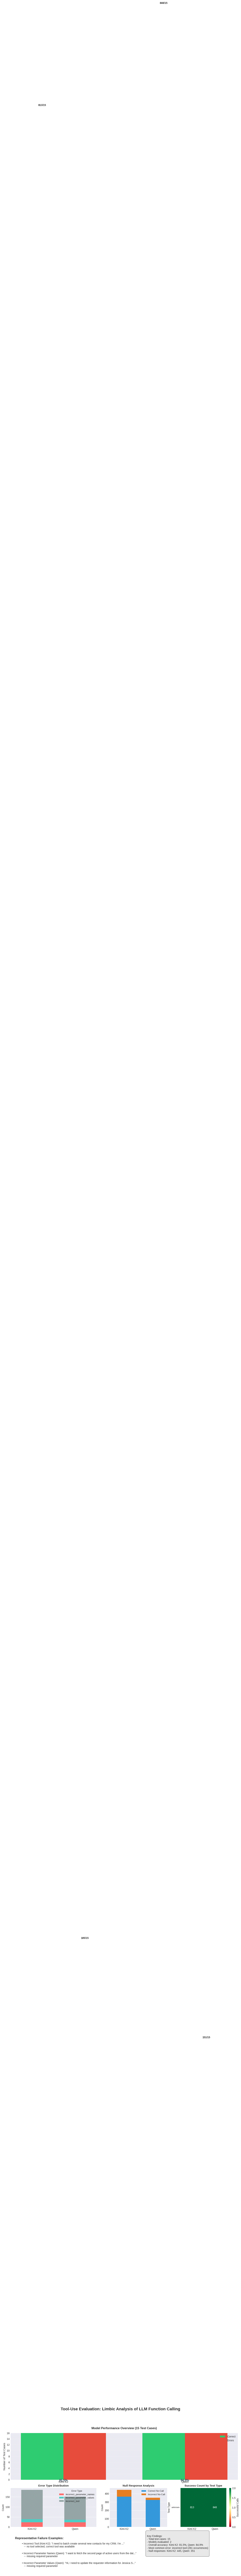

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

# Convert to DataFrame
results_df = pd.DataFrame(detailed_results)

# results_df.to_csv(f"evaluation_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv", index=False)

# Set style for professional appearance
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with better layout
fig = plt.figure(figsize=(16, 10))
fig.suptitle('Tool-Use Evaluation: Limbic Analysis of LLM Function Calling',
             fontsize=16, fontweight='bold', y=1.02)

# Create grid with specific sizing
gs = fig.add_gridspec(3, 3, height_ratios=[1.2, 1, 1], width_ratios=[1.5, 1, 1])

# 1. MAIN CHART: Overall Performance Comparison
ax1 = fig.add_subplot(gs[0, :])

# Calculate metrics properly
models_data = []
for model in results_df['model'].unique():
    model_df = results_df[results_df['model'] == model]
    total = len(model_df)
    correct = (model_df['limbic_score'] == 'correct').sum()

    models_data.append({
        'Model': model,
        'Correct': correct,
        'Errors': total - correct,
        'Total': total,
        'Accuracy': (correct / total * 100)
    })

perf_df = pd.DataFrame(models_data)

# Create grouped bar chart
x = np.arange(len(perf_df))
width = 0.35

bars1 = ax1.bar(x - width/2, perf_df['Correct'], width, label='Correct', color='#2ECC71')
bars2 = ax1.bar(x + width/2, perf_df['Errors'], width, label='Errors', color='#E74C3C')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}/15', ha='center', va='bottom', fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}/15', ha='center', va='bottom', fontweight='bold')

# Add accuracy percentages
for i, (idx, row) in enumerate(perf_df.iterrows()):
    ax1.text(i, -0.5, f'{row["Accuracy"]:.1f}%', ha='center',
             fontweight='bold', fontsize=12, color='#34495E')

ax1.set_ylabel('Number of Test Cases', fontsize=11)
ax1.set_title('Model Performance Overview (15 Test Cases)', fontsize=12, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(perf_df['Model'], fontsize=11)
ax1.legend(loc='upper right', fontsize=10)
ax1.set_ylim([0, 16])
ax1.grid(axis='y', alpha=0.3)

# 2. Error Type Distribution
ax2 = fig.add_subplot(gs[1, 0])

# Get error distribution
error_types = results_df[results_df['limbic_score'] != 'correct'].groupby(
    ['model', 'limbic_score']).size().unstack(fill_value=0)

if not error_types.empty:
    error_types.plot(kind='bar', stacked=True, ax=ax2,
                     color=['#FF6B6B', '#4ECDC4', '#95A5A6'])
    ax2.set_title('Error Type Distribution', fontsize=11, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('Count', fontsize=10)
    ax2.legend(title='Error Type', fontsize=9, title_fontsize=9)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
else:
    ax2.text(0.5, 0.5, 'No errors found', ha='center', va='center')

# 3. Null Response Analysis
ax3 = fig.add_subplot(gs[1, 1])

null_data = []
for model in results_df['model'].unique():
    model_df = results_df[results_df['model'] == model]
    null_count = model_df['was_null_response'].sum()
    null_correct = ((model_df['was_null_response'] == True) &
                   (model_df['limbic_score'] == 'correct')).sum()
    null_incorrect = null_count - null_correct

    null_data.append({
        'Model': model,
        'Correct No-Call': null_correct,
        'Incorrect No-Call': null_incorrect
    })

null_df = pd.DataFrame(null_data)
null_df.set_index('Model')[['Correct No-Call', 'Incorrect No-Call']].plot(
    kind='bar', stacked=True, ax=ax3, color=['#3498DB', '#E67E22'])
ax3.set_title('Null Response Analysis', fontsize=11, fontweight='bold')
ax3.set_xlabel('')
ax3.set_ylabel('Count', fontsize=10)
ax3.legend(fontsize=9)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)

# 4. Test Type Performance
ax4 = fig.add_subplot(gs[1, 2])

# Calculate success rate by test type
test_perf = results_df.pivot_table(
    index='test_type',
    columns='model',
    values='limbic_score',
    aggfunc=lambda x: (x == 'correct').sum()
).fillna(0)

# Only show test types with at least one evaluation
test_counts = results_df.groupby('test_type').size()
test_perf['Total Tests'] = test_counts
test_perf = test_perf[test_perf['Total Tests'] > 0]

# Show as heatmap with counts (not percentages)
sns.heatmap(test_perf[results_df['model'].unique()],
            annot=True, fmt='.0f', cmap='RdYlGn',
            ax=ax4, vmin=0, vmax=2,
            cbar_kws={'label': 'Successful Calls'})
ax4.set_title('Success Count by Test Type', fontsize=11, fontweight='bold')
ax4.set_xlabel('')
ax4.set_ylabel('Test Type', fontsize=10)
ax4.set_yticklabels(ax4.get_yticklabels(), rotation=0, fontsize=8)

# 5. Specific Failure Examples
ax5 = fig.add_subplot(gs[2, :])
ax5.axis('off')

# Collect interesting failure examples
failure_examples = []
errors = results_df[results_df['limbic_score'] != 'correct']

# Group by error type for diversity
for error_type in errors['limbic_score'].unique():
    example = errors[errors['limbic_score'] == error_type].iloc[0]
    failure_examples.append({
        'Type': error_type.replace('_', ' ').title(),
        'Model': example['model'],
        'Test': example['test_type'],
        'Prompt': example['user_prompt'][:60] + '...',
        'Issue': example['limbic_reasoning'][0] if example['limbic_reasoning'] else 'No reason provided'
    })

# Create table of examples
if failure_examples:
    ax5.text(0.02, 0.9, 'Representative Failure Examples:',
             fontsize=12, fontweight='bold')

    y_pos = 0.7
    for i, ex in enumerate(failure_examples[:3]):  # Show top 3
        text = f"• {ex['Type']} ({ex['Model']}): \"{ex['Prompt']}\"\n  → {ex['Issue']}"
        ax5.text(0.05, y_pos - i*0.25, text, fontsize=10, wrap=True)

# Add summary statistics box
summary_text = f"""
Key Findings:
- Total test cases: 15
- Models evaluated: {results_df['model'].nunique()}
- Overall accuracy: Kimi K2: {perf_df[perf_df['Model']=='Kimi K2']['Accuracy'].values[0]:.1f}%, Qwen: {perf_df[perf_df['Model']=='Qwen']['Accuracy'].values[0]:.1f}%
- Most common error: {errors['limbic_score'].mode()[0].replace('_', ' ')} ({errors['limbic_score'].value_counts().iloc[0]} occurrences)
- Null responses: Kimi K2: {results_df[(results_df['model']=='Kimi K2') & (results_df['was_null_response']==True)].shape[0]}, Qwen: {results_df[(results_df['model']=='Qwen') & (results_df['was_null_response']==True)].shape[0]}
"""

ax5.text(0.6, 0.5, summary_text, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.5))

plt.tight_layout()
plt.savefig(f'blog_evaluation_visualization_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png',
            dpi=150, bbox_inches='tight')
plt.show()

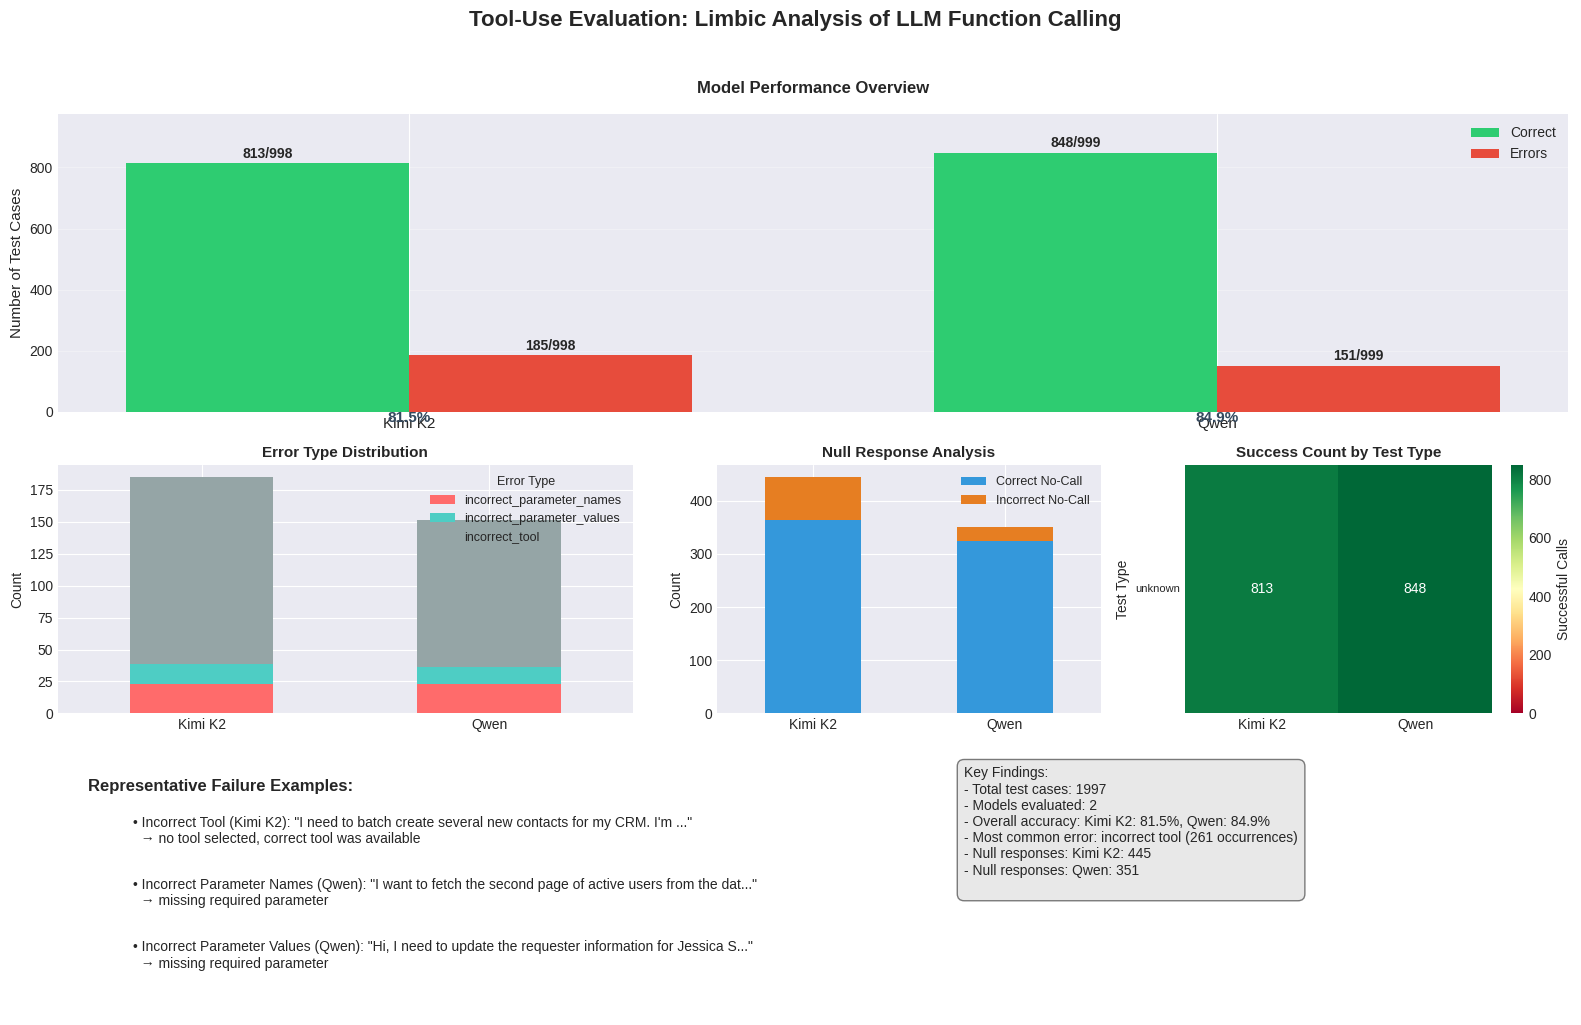

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

# Convert to DataFrame
results_df = pd.DataFrame(detailed_results)

# Optional: persist raw results
# results_df.to_csv(f"evaluation_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv", index=False)

# -------- General style --------
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# -------- Figure + grid --------
fig = plt.figure(figsize=(16, 10))
fig.suptitle('Tool-Use Evaluation: Limbic Analysis of LLM Function Calling',
             fontsize=16, fontweight='bold', y=1.02)
gs = fig.add_gridspec(3, 3, height_ratios=[1.2, 1, 1], width_ratios=[1.5, 1, 1])

# =========================================================
# 1) MAIN CHART: Overall Performance Comparison (dynamic)
# =========================================================
ax1 = fig.add_subplot(gs[0, :])

models_data = []
for model in results_df['model'].dropna().unique():
    model_df = results_df[results_df['model'] == model]
    total = len(model_df)
    correct = (model_df['limbic_score'] == 'correct').sum()
    models_data.append({
        'Model': model,
        'Correct': int(correct),
        'Errors': int(total - correct),
        'Total': int(total),
        'Accuracy': (correct / total * 100) if total > 0 else 0.0
    })

perf_df = pd.DataFrame(models_data).sort_values('Model').reset_index(drop=True)
x = np.arange(len(perf_df))
width = 0.35

bars1 = ax1.bar(x - width/2, perf_df['Correct'], width, label='Correct', color='#2ECC71')
bars2 = ax1.bar(x + width/2, perf_df['Errors'], width, label='Errors', color='#E74C3C')

# Dynamic headroom for labels
ymax = max(perf_df[['Correct', 'Errors']].to_numpy().max(), 1)
ax1.set_ylim([0, ymax * 1.15])

# Value labels (count/total)
for i, bar in enumerate(bars1):
    h = bar.get_height()
    total = perf_df.loc[i, 'Total']
    ax1.text(bar.get_x() + bar.get_width()/2., h + ymax*0.01,
             f'{int(h)}/{int(total)}', ha='center', va='bottom', fontweight='bold', fontsize=10)

for i, bar in enumerate(bars2):
    h = bar.get_height()
    total = perf_df.loc[i, 'Total']
    ax1.text(bar.get_x() + bar.get_width()/2., h + ymax*0.01,
             f'{int(h)}/{int(total)}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Accuracy labels below ticks
for i, row in perf_df.iterrows():
    ax1.text(i, -ymax*0.04, f'{row["Accuracy"]:.1f}%', ha='center',
             fontweight='bold', fontsize=11, color='#34495E')

ax1.set_ylabel('Number of Test Cases', fontsize=11)
ax1.set_title('Model Performance Overview', fontsize=12, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(perf_df['Model'], fontsize=11)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# =======================================
# 2) Error Type Distribution (stacked)
# =======================================
ax2 = fig.add_subplot(gs[1, 0])

errors_df = results_df[results_df['limbic_score'] != 'correct']
error_types = (errors_df.groupby(['model', 'limbic_score'])
               .size()
               .unstack(fill_value=0)
               .sort_index())

if not error_types.empty:
    # Use pandas plot for convenience; colors are fine as provided
    error_types.plot(kind='bar', stacked=True, ax=ax2,
                     color=['#FF6B6B', '#4ECDC4', '#95A5A6', '#F1C40F', '#9B59B6'][:len(error_types.columns)])
    ax2.set_title('Error Type Distribution', fontsize=11, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('Count', fontsize=10)
    ax2.legend(title='Error Type', fontsize=9, title_fontsize=9)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
else:
    ax2.set_title('Error Type Distribution', fontsize=11, fontweight='bold')
    ax2.text(0.5, 0.5, 'No errors found', ha='center', va='center')
    ax2.set_xticks([])
    ax2.set_yticks([])

# =======================================
# 3) Null Response Analysis
# =======================================
ax3 = fig.add_subplot(gs[1, 1])

null_rows = []
for model in results_df['model'].dropna().unique():
    model_df = results_df[results_df['model'] == model]
    null_mask = model_df['was_null_response'] == True
    null_count = int(null_mask.sum())
    null_correct = int((null_mask & (model_df['limbic_score'] == 'correct')).sum())
    null_incorrect = int(null_count - null_correct)
    null_rows.append({
        'Model': model,
        'Correct No-Call': null_correct,
        'Incorrect No-Call': null_incorrect
    })

null_df = pd.DataFrame(null_rows).set_index('Model')
if not null_df.empty:
    null_df[['Correct No-Call', 'Incorrect No-Call']].plot(
        kind='bar', stacked=True, ax=ax3, color=['#3498DB', '#E67E22'])
    ax3.set_title('Null Response Analysis', fontsize=11, fontweight='bold')
    ax3.set_xlabel('')
    ax3.set_ylabel('Count', fontsize=10)
    ax3.legend(fontsize=9)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
else:
    ax3.set_title('Null Response Analysis', fontsize=11, fontweight='bold')
    ax3.text(0.5, 0.5, 'No null responses', ha='center', va='center')
    ax3.set_xticks([])
    ax3.set_yticks([])

# =======================================
# 4) Test Type Performance (heatmap of counts)
# =======================================
ax4 = fig.add_subplot(gs[1, 2])

# Successful counts by test_type x model
test_perf = results_df.pivot_table(
    index='test_type',
    columns='model',
    values='limbic_score',
    aggfunc=lambda x: (x == 'correct').sum()
).fillna(0).astype(int)

if not test_perf.empty:
    vmax = max(test_perf.values.max(), 1)  # dynamic upper bound
    sns.heatmap(test_perf.loc[:, test_perf.columns],  # keep all models present
                annot=True, fmt='.0f', cmap='RdYlGn',
                ax=ax4, vmin=0, vmax=vmax,
                cbar_kws={'label': 'Successful Calls'})
    ax4.set_title('Success Count by Test Type', fontsize=11, fontweight='bold')
    ax4.set_xlabel('')
    ax4.set_ylabel('Test Type', fontsize=10)
    ax4.set_yticklabels(ax4.get_yticklabels(), rotation=0, fontsize=8)
else:
    ax4.set_title('Success Count by Test Type', fontsize=11, fontweight='bold')
    ax4.text(0.5, 0.5, 'No test types found', ha='center', va='center')
    ax4.set_xticks([])
    ax4.set_yticks([])

# =======================================
# 5) Specific Failure Examples + Summary
# =======================================
ax5 = fig.add_subplot(gs[2, :])
ax5.axis('off')

failure_examples = []
errors = results_df[results_df['limbic_score'] != 'correct']

if not errors.empty:
    # One representative per error type (diversity)
    for error_type in errors['limbic_score'].unique():
        ex = errors[errors['limbic_score'] == error_type].iloc[0]
        reasoning = ex['limbic_reasoning']
        issue = ''
        # limbic_reasoning may be list/str/None; make robust
        if isinstance(reasoning, list) and reasoning:
            issue = reasoning[0]
        elif isinstance(reasoning, str):
            issue = reasoning
        failure_examples.append({
            'Type': error_type.replace('_', ' ').title(),
            'Model': ex['model'],
            'Test': ex['test_type'],
            'Prompt': (ex['user_prompt'][:60] + '...') if isinstance(ex['user_prompt'], str) and len(ex['user_prompt']) > 60 else ex['user_prompt'],
            'Issue': issue if issue else 'No reason provided'
        })

if failure_examples:
    ax5.text(0.02, 0.9, 'Representative Failure Examples:',
             fontsize=12, fontweight='bold')
    y_pos = 0.7
    for i, ex in enumerate(failure_examples[:3]):  # top 3 diverse cases
        text = f"• {ex['Type']} ({ex['Model']}): \"{ex['Prompt']}\"\n  → {ex['Issue']}"
        ax5.text(0.05, y_pos - i*0.25, text, fontsize=10, wrap=True)

# Summary box (dynamic, no hard-coded 15)
total_cases = len(results_df)
n_models = results_df['model'].nunique()

# Handle cases where there are no errors at all
if not errors.empty:
    most_common_error = errors['limbic_score'].mode()[0]
    most_common_error_count = errors['limbic_score'].value_counts().iloc[0]
    most_common_error_name = most_common_error.replace('_', ' ')
else:
    most_common_error_name = 'none'
    most_common_error_count = 0

# Build per-model accuracy line dynamically
acc_lines = []
for _, row in perf_df.iterrows():
    acc_lines.append(f"{row['Model']}: {row['Accuracy']:.1f}%")

summary_text = (
    "Key Findings:\n"
    f"- Total test cases: {total_cases}\n"
    f"- Models evaluated: {n_models}\n"
    f"- Overall accuracy: " + ", ".join(acc_lines) + "\n"
    f"- Most common error: {most_common_error_name} ({most_common_error_count} occurrences)\n"
)

# Null responses per model
for model in perf_df['Model']:
    null_count = results_df[(results_df['model'] == model) & (results_df['was_null_response'] == True)].shape[0]
    summary_text += f"- Null responses: {model}: {null_count}\n"

ax5.text(0.6, 0.5, summary_text, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.5))

plt.tight_layout()
plt.savefig(f'blog_evaluation_visualization_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png',
            dpi=150, bbox_inches='tight')
plt.show()


## Generate insights

In [15]:
# Calculate key metrics
total_evaluations = len(results_df)
unique_examples = results_df['example_id'].nunique()

print(f"\nDataset Overview:")
print(f"- Examples tested: {unique_examples}")
print(f"- Models evaluated: {results_df['model'].nunique()}")
print(f"- Total evaluations: {total_evaluations}")

print(f"\nPerformance Summary:")
for model in results_df['model'].unique():
    model_df = results_df[results_df['model'] == model]
    accuracy = (model_df['limbic_score'] == 'correct').mean() * 100
    null_rate = model_df['was_null_response'].mean() * 100
    print(f"\n{model}:")
    print(f"  - Accuracy: {accuracy:.1f}%")
    print(f"  - Null response rate: {null_rate:.1f}%")

    # Most common error
    errors = model_df[model_df['limbic_score'] != 'correct']['limbic_score']
    if len(errors) > 0:
        print(f"  - Most common error: {errors.mode()[0]}")

print(f"\nKey Findings:")
# Null response insight
null_responses = results_df[results_df['was_null_response'] == True]
if len(null_responses) > 0:
    print(f"- {len(null_responses)} cases where models didn't call any tool")
    null_correct = null_responses[null_responses['limbic_score'] == 'correct']
    print(f"  - {len(null_correct)} were correctly identified as not needing tools")
    null_wrong = null_responses[null_responses['limbic_score'] != 'correct']
    print(f"  - {len(null_wrong)} should have called a tool but didn't")

# Error patterns
print(f"\nError Patterns:")
error_dist = results_df[results_df['limbic_score'] != 'correct']['limbic_score'].value_counts()
for error_type, count in error_dist.items():
    examples = results_df[results_df['limbic_score'] == error_type]['test_type'].value_counts().head(1)
    if len(examples) > 0:
        print(f"- {error_type}: {count} occurrences, most common in '{examples.index[0]}' tests")


Dataset Overview:
- Examples tested: 1000
- Models evaluated: 2
- Total evaluations: 1997

Performance Summary:

Kimi K2:
  - Accuracy: 81.5%
  - Null response rate: 44.6%
  - Most common error: incorrect_tool

Qwen:
  - Accuracy: 84.9%
  - Null response rate: 35.1%
  - Most common error: incorrect_tool

Key Findings:
- 796 cases where models didn't call any tool
  - 689 were correctly identified as not needing tools
  - 107 should have called a tool but didn't

Error Patterns:
- incorrect_tool: 261 occurrences, most common in 'unknown' tests
- incorrect_parameter_names: 46 occurrences, most common in 'unknown' tests
- incorrect_parameter_values: 29 occurrences, most common in 'unknown' tests


## Detailed analysis of failure cases

In [22]:
import pandas as pd
import json

def normalize_reasoning(x):
    """Ensure limbic_reasoning is always a list of strings."""
    if isinstance(x, list):
        return [str(i) for i in x]
    if isinstance(x, str):
        try:
            parsed = json.loads(x)
            if isinstance(parsed, list):
                return [str(i) for i in parsed]
            return [x]
        except Exception:
            return [x]
    return []

def analyze_failure_patterns(results_df, models=("Kimi K2", "Qwen")):
    # Normalize schema
    results_df = results_df.copy()
    if "tool_called" not in results_df.columns:
        results_df["tool_called"] = "N/A"
    results_df["was_null_response"] = results_df["was_null_response"].astype(bool)
    results_df["limbic_reasoning"] = results_df["limbic_reasoning"].apply(normalize_reasoning)

    # Ensure one row per (example_id, model)
    results_df = (
        results_df.sort_values(by=["example_id", "model"])
        .drop_duplicates(subset=["example_id", "model"], keep="last")
    )

    # 1. Failures in first model but success in second
    print("-"*50)
    print(f"FAILURES IN {models[0]} BUT SUCCESS IN {models[1]}:")
    print("-"*50)
    for ex_id, grp in results_df.groupby("example_id"):
        if set(models).issubset(grp["model"].unique()):
            row_a = grp[grp["model"] == models[0]].iloc[0]
            row_b = grp[grp["model"] == models[1]].iloc[0]
            if row_a["limbic_score"] != "correct" and row_b["limbic_score"] == "correct":
                print(f"\nExample {ex_id}:")
                print(f"Prompt: {row_a['user_prompt'][:100]}...")
                print(f"{models[0]} failed: {row_a['limbic_score']} - {', '.join(row_a['limbic_reasoning'])}")
                print(f"{models[1]} succeeded: tool={row_b['tool_called']}")

    # 2. Failures in both
    print("\n" + "-"*50)
    print("FAILURES IN BOTH MODELS:")
    print("-"*50)
    for ex_id, grp in results_df.groupby("example_id"):
        if set(models).issubset(grp["model"].unique()):
            row_a = grp[grp["model"] == models[0]].iloc[0]
            row_b = grp[grp["model"] == models[1]].iloc[0]
            if row_a["limbic_score"] != "correct" and row_b["limbic_score"] != "correct":
                print(f"\nExample {ex_id}:")
                print(f"Prompt: {row_a['user_prompt'][:100]}...")
                print(f"{models[0]}: {row_a['limbic_score']} - {', '.join(row_a['limbic_reasoning'])}")
                print(f"{models[1]}: {row_b['limbic_score']} - {', '.join(row_b['limbic_reasoning'])}")

    # 3. Null responses
    print("\n" + "-"*50)
    print("NULL RESPONSES:")
    print("-"*50)
    nulls = results_df[results_df["was_null_response"]]
    if not nulls.empty:
        for _, row in nulls.iterrows():
            print(f"\nModel: {row['model']}, Example {row['example_id']}")
            print(f"Prompt: {row['user_prompt'][:100]}...")
            print(f"Score: {row['limbic_score']} | Reasoning: {', '.join(row['limbic_reasoning'])}")
    else:
        print("None found.")


In [23]:
results_df = pd.DataFrame(detailed_results)
analyze_failure_patterns(results_df)

--------------------------------------------------
FAILURES IN Kimi K2 BUT SUCCESS IN Qwen:
--------------------------------------------------

Example 1:
Prompt: I need to batch create several new contacts for my CRM. I'm working on importing data from an old sy...
Kimi K2 failed: incorrect_tool - no tool selected, correct tool was available
Qwen succeeded: tool=crm_batch_create_objects

Example 57:
Prompt: I have just completed a new programming module that automates data entry tasks. Before deploying it,...
Kimi K2 failed: incorrect_tool - no tool selected, correct tool was available
Qwen succeeded: tool=NO_TOOL_CALLED

Example 60:
Prompt: I need to fetch all the canned responses from the 'Customer Feedback' folder in Freshdesk to help ou...
Kimi K2 failed: incorrect_tool - no tool selected, correct tool was available
Qwen succeeded: tool=list_canned_responses

Example 69:
Prompt: Hey team, can we update the name of the 'Games' category to 'Updated Games Category'? Also, let's mo...

In [20]:
print("\n" + "-"*50)
print("ERROR DISTRIBUTION BY MODEL:")
print("-"*50)
error_summary = pd.crosstab(
    results_df[results_df["limbic_score"] != "correct"]["limbic_score"],
    results_df[results_df["limbic_score"] != "correct"]["model"]
)
print(error_summary if not error_summary.empty else "No errors")

results_df


--------------------------------------------------
ERROR DISTRIBUTION BY MODEL:
--------------------------------------------------
model                       Kimi K2  Qwen
limbic_score                             
incorrect_parameter_names        23    23
incorrect_parameter_values       16    13
incorrect_tool                  146   115


,example_id,test_type,model,user_prompt,tool_called,tool_params,limbic_score,limbic_reasoning,was_null_response,ground_truth
0,1,unknown,Kimi K2,I need to batch create several new contacts fo...,NO_TOOL_CALLED,None,incorrect_tool,"[no tool selected, correct tool was available]",True,None
1,1,unknown,Qwen,I need to batch create several new contacts fo...,crm_batch_create_objects,{'inputs': [{'associations': [{'to': {'id': '1...,correct,[],False,None
2,2,unknown,Kimi K2,I noticed that our 'web-server-01' host has be...,NO_TOOL_CALLED,None,correct,[],True,None
3,2,unknown,Qwen,I noticed that our 'web-server-01' host has be...,NO_TOOL_CALLED,None,correct,[],True,None
4,3,unknown,Kimi K2,Can you show me the contents of the images dir...,NO_TOOL_CALLED,None,correct,[],True,None
...,...,...,...,...,...,...,...,...,...,...
1992,998,unknown,Qwen,I'm looking to connect with software engineers...,openai_computer_use_agent,"{'maxSteps': 25, 'task': 'Search for software ...",correct,[],False,None
1993,999,unknown,Kimi K2,I'm working on a data analysis project and I n...,NO_TOOL_CALLED,None,correct,[],True,None
1994,999,unknown,Qwen,I'm working on a data analysis project and I n...,geminithinking,"{'nextThoughtNeeded': True, 'query': 'How to l...",incorrect_tool,[incorrect function selected from available op...,False,None
1995,1000,unknown,Kimi K2,I'm managing my team's project on Monday.com a...,monday-list-subitems-in-items,"{'itemIds': ['123456', '789101', '112131']}",correct,[],False,None
